In [16]:
import os
import re
import shutil
from os import listdir
from os.path import isfile, join

import numpy as np
from CSIKit.reader import get_reader
from CSIKit.util import csitools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
## Creating dataset without service subcarriers
### Data downloading

In [17]:
def getCsiMatrFromPcap(fileName: str, CsiFilesFolder: str) -> pd.DataFrame:
    pcapFilePath = join(CsiFilesFolder, fileName)
    my_reader = get_reader(pcapFilePath)
    csi_data = my_reader.read_file(pcapFilePath, scaled=False)
    csi_matrix, no_frames, no_subcarriers = csitools.get_CSI(csi_data, metric="amplitude")
    csi_matrix = csi_matrix[:, :, 0, 0]
    csi_matrix = pd.DataFrame(csi_matrix)
    return csi_matrix

def getCsiMatrFromCsv(fileName: str, CsiFilesFolder: str) -> pd.DataFrame:
    if ".csv" not in fileName:
        if "." not in fileName:
            fileName += ".csv"
        else:
            # .pcap
            fileName = fileName[:-5] + ".csv"

    csvFilePath = join(CsiFilesFolder, fileName)
    return pd.read_csv(csvFilePath)

def removeFolder(folderPath: str):
    filesNames = os.listdir(folderPath)
    for fileName in filesNames:
        if isfile(join(folderPath, fileName)):
            os.remove(join(folderPath, fileName))
        else:
            removeFolder(join(folderPath, fileName))
    try:
        os.rmdir(folderPath)
    except PermissionError:
        pass

In [18]:
csi_cvs_folder = "dataset1"
if os.path.exists(csi_cvs_folder):
    removeFolder(csi_cvs_folder)

os.mkdir(csi_cvs_folder)

csi_data_folder = "CSICapturedFiles/csi_data1"
neededActionTypes = ["nothing", "walk"]
csiFiles = [fileName
            for fileName in listdir(csi_data_folder)
            if isfile(join(csi_data_folder, fileName)) and re.sub(r"_\d{1,10}.pcap", "", fileName) in neededActionTypes]


csi_dict: {str: pd.DataFrame} = dict()
for fileName in csiFiles:
    csi_matrix = getCsiMatrFromPcap(fileName, csi_data_folder)
    # csi_matrix.head(2)
    csi_dict[fileName] = csi_matrix

# csi_dict
# NEXBeamformReader.read_bfee

In [19]:
csi_matrix

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,18.129134,34.737788,18.573325,12.304489,20.969100,14.149733,51.476423,54.916208,57.243414,58.866627,...,52.415290,55.576335,57.516678,58.784281,59.660013,13.979400,19.867717,16.532125,17.242759,16.020600
1,17.634280,34.737788,16.127839,12.304489,17.160033,13.979400,12.304489,11.139434,12.041200,15.563025,...,12.041200,14.623980,9.030900,20.969100,19.867717,21.846914,21.958997,15.051500,12.041200,12.041200
2,13.010300,34.737788,12.304489,9.542425,18.061800,12.041200,52.710629,54.801824,55.919201,57.096032,...,49.819997,52.751385,54.793118,56.439262,57.005255,13.979400,10.000000,13.979400,18.129134,13.979400
3,13.979400,34.737788,6.020600,0.000000,17.242759,0.000000,54.104887,55.756150,57.274111,58.177676,...,50.936773,52.958946,54.191260,54.801349,55.366519,6.989700,21.613680,-inf,18.129134,11.139434
4,16.127839,34.737788,11.139434,17.634280,14.623980,9.030900,55.689828,56.599400,57.932881,58.870961,...,49.176998,49.630035,51.799250,53.442606,55.069810,9.030900,11.139434,21.613680,20.374265,14.149733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,20.969100,34.737788,3.010300,11.139434,20.000000,16.020600,50.371794,53.507596,55.497706,57.193288,...,44.294454,50.086853,53.924754,56.330420,57.717381,3.010300,14.623980,22.095150,16.020600,15.051500
338,15.314789,34.737788,21.702617,9.542425,19.493900,17.242759,51.279111,53.956147,56.251478,57.739283,...,45.340515,51.008700,54.385566,56.325433,57.617024,14.149733,14.149733,11.139434,16.532125,9.030900
339,12.552725,34.737788,9.030900,12.304489,3.010300,15.314789,12.304489,14.149733,12.552725,18.325089,...,18.129134,18.061800,3.010300,16.020600,9.542425,18.129134,6.020600,12.304489,6.989700,12.304489
340,17.160033,34.737788,13.979400,17.160033,17.634280,21.139434,50.534357,52.923624,55.547677,56.861016,...,47.380350,52.013562,54.844621,56.147338,57.517532,23.979400,17.242759,6.020600,3.010300,15.682017


### service subcarriers extracting

I wanted
to go through all files and all packets in each file.

Then if subcarrier have value, that is greater than 75%-th quantile of values in packet, it gets one vote.

Number of all votes equals sum of number of packets in each file.

If subcarrier has more than 70% of all votes, it is a service subcarrier.

But mentor said to google indexes of service subcarriers

In [20]:
# service subcarriers
trashSubcarriers = np.array([0, 1] + list(range(123, 134))+ [255])

In [21]:
print("service subcarriers:", trashSubcarriers)

service subcarriers: [  0   1 123 124 125 126 127 128 129 130 131 132 133 255]


In [22]:
for fileName in csi_dict:
    csi_dict[fileName] = csi_dict[fileName].drop(columns=trashSubcarriers)

##### file with service subcarriers, one packet plot

Text(0, 0.5, 'amplitude')

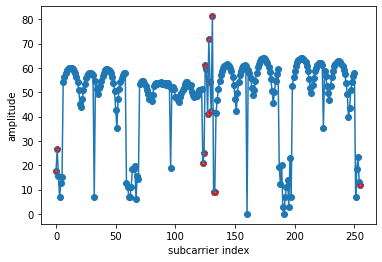

In [23]:
fileName = list(csi_dict.keys())[0]
csi_matrix = getCsiMatrFromPcap(fileName, csi_data_folder)
packet = csi_matrix.iloc[0]
packet.plot.line(legend=False)
plt.scatter(packet.index.values, packet.values)

plt.scatter(trashSubcarriers, packet.values[trashSubcarriers], edgecolors="red", marker="*")
plt.xlabel("subcarrier index")
plt.ylabel("amplitude")

Text(33.0, 0.5, 'subcarrier index')

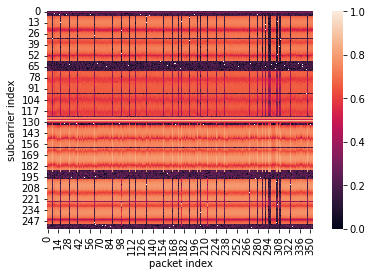

In [24]:
maxVal = csi_matrix.max().max()
csi_matrix = csi_matrix / maxVal

sns.heatmap(csi_matrix.T, vmin=0, vmax=csi_matrix.values.max())
plt.xlabel("packet index")
plt.ylabel("subcarrier index")

##### file without service subcarriers, one packet plot

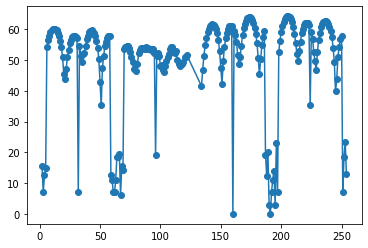

In [25]:
csi_matrix = csi_dict[fileName]
packet = csi_matrix.iloc[0]
packet.plot.line(legend=False)
plt.scatter(packet.index.values, packet.values)

Text(33.0, 0.5, 'subcarrier index')

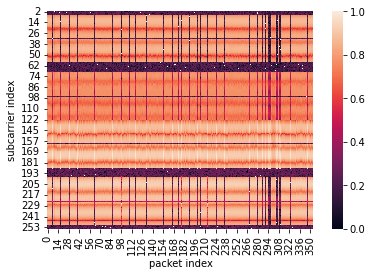

In [26]:
maxVal = csi_matrix.max().max()
csi_matrix = csi_matrix / maxVal

sns.heatmap(csi_matrix.T, vmin=0, vmax=csi_matrix.values.max())
plt.xlabel("packet index")
plt.ylabel("subcarrier index")

### uploading csi amplitude matrices into csv files

In [27]:
csi_cvs_folder

'dataset1'

In [28]:
for fileName in csi_dict:
    csvFileName = fileName[:-5] + ".csv"
    csi_dict[fileName].to_csv(join(csi_cvs_folder, csvFileName), index=False)

##### csi matrix from csv file

,2,3,4,5,6,7,8,9,10,11,...,245,246,247,248,249,250,251,252,253,254
0,18.573325,12.304489,20.969100,14.149733,51.476423,54.916208,57.243414,58.866627,59.750640,60.321726,...,45.706597,52.415290,55.576335,57.516678,58.784281,59.660013,13.979400,19.867717,16.532125,17.242759
1,16.127839,12.304489,17.160033,13.979400,12.304489,11.139434,12.041200,15.563025,20.170333,14.623980,...,22.304489,12.041200,14.623980,9.030900,20.969100,19.867717,21.846914,21.958997,15.051500,12.041200
2,12.304489,9.542425,18.061800,12.041200,52.710629,54.801824,55.919201,57.096032,57.685626,58.247927,...,45.835388,49.819997,52.751385,54.793118,56.439262,57.005255,13.979400,10.000000,13.979400,18.129134
3,6.020600,0.000000,17.242759,0.000000,54.104887,55.756150,57.274111,58.177676,58.578563,58.774474,...,48.178165,50.936773,52.958946,54.191260,54.801349,55.366519,6.989700,21.613680,-inf,18.129134
4,11.139434,17.634280,14.623980,9.030900,55.689828,56.599400,57.932881,58.870961,59.853838,60.438721,...,50.022352,49.176998,49.630035,51.799250,53.442606,55.069810,9.030900,11.139434,21.613680,20.374265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,3.010300,11.139434,20.000000,16.020600,50.371794,53.507596,55.497706,57.193288,58.343323,59.208999,...,43.878346,44.294454,50.086853,53.924754,56.330420,57.717381,3.010300,14.623980,22.095150,16.020600
338,21.702617,9.542425,19.493900,17.242759,51.279111,53.956147,56.251478,57.739283,58.632765,59.345570,...,43.197305,45.340515,51.008700,54.385566,56.325433,57.617024,14.149733,14.149733,11.139434,16.532125
339,9.030900,12.304489,3.010300,15.314789,12.304489,14.149733,12.552725,18.325089,14.149733,11.139434,...,11.139434,18.129134,18.061800,3.010300,16.020600,9.542425,18.129134,6.020600,12.304489,6.989700
340,13.979400,17.160033,17.634280,21.139434,50.534357,52.923624,55.547677,56.861016,58.052731,58.765579,...,40.552636,47.380350,52.013562,54.844621,56.147338,57.517532,23.979400,17.242759,6.020600,3.010300


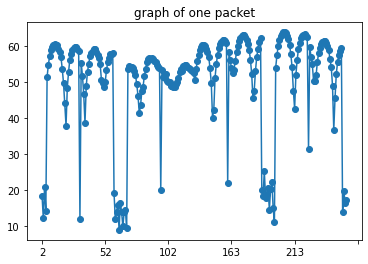

In [29]:
csi_matrix = getCsiMatrFromCsv(fileName, csi_cvs_folder)
packet = csi_matrix.iloc[0]
packet.plot.line(legend=False)
plt.scatter(packet.index.values, packet.values)
plt.title("graph of one packet")

csi_matrix

##### csi matrix from csi_dict

,2,3,4,5,6,7,8,9,10,11,...,245,246,247,248,249,250,251,252,253,254
0,18.573325,12.304489,20.969100,14.149733,51.476423,54.916208,57.243414,58.866627,59.750640,60.321726,...,45.706597,52.415290,55.576335,57.516678,58.784281,59.660013,13.979400,19.867717,16.532125,17.242759
1,16.127839,12.304489,17.160033,13.979400,12.304489,11.139434,12.041200,15.563025,20.170333,14.623980,...,22.304489,12.041200,14.623980,9.030900,20.969100,19.867717,21.846914,21.958997,15.051500,12.041200
2,12.304489,9.542425,18.061800,12.041200,52.710629,54.801824,55.919201,57.096032,57.685626,58.247927,...,45.835388,49.819997,52.751385,54.793118,56.439262,57.005255,13.979400,10.000000,13.979400,18.129134
3,6.020600,0.000000,17.242759,0.000000,54.104887,55.756150,57.274111,58.177676,58.578563,58.774474,...,48.178165,50.936773,52.958946,54.191260,54.801349,55.366519,6.989700,21.613680,-inf,18.129134
4,11.139434,17.634280,14.623980,9.030900,55.689828,56.599400,57.932881,58.870961,59.853838,60.438721,...,50.022352,49.176998,49.630035,51.799250,53.442606,55.069810,9.030900,11.139434,21.613680,20.374265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,3.010300,11.139434,20.000000,16.020600,50.371794,53.507596,55.497706,57.193288,58.343323,59.208999,...,43.878346,44.294454,50.086853,53.924754,56.330420,57.717381,3.010300,14.623980,22.095150,16.020600
338,21.702617,9.542425,19.493900,17.242759,51.279111,53.956147,56.251478,57.739283,58.632765,59.345570,...,43.197305,45.340515,51.008700,54.385566,56.325433,57.617024,14.149733,14.149733,11.139434,16.532125
339,9.030900,12.304489,3.010300,15.314789,12.304489,14.149733,12.552725,18.325089,14.149733,11.139434,...,11.139434,18.129134,18.061800,3.010300,16.020600,9.542425,18.129134,6.020600,12.304489,6.989700
340,13.979400,17.160033,17.634280,21.139434,50.534357,52.923624,55.547677,56.861016,58.052731,58.765579,...,40.552636,47.380350,52.013562,54.844621,56.147338,57.517532,23.979400,17.242759,6.020600,3.010300


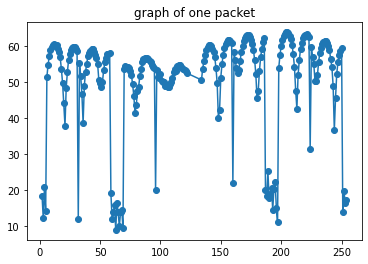

In [30]:
csi_matrix = csi_dict[fileName]
packet = csi_matrix.iloc[0]
packet.plot.line(legend=False)
plt.scatter(packet.index.values, packet.values)
plt.title("graph of one packet")
csi_matrix